### 1-D Richards equation solver code
- formulation based on a backward Euler implementation of the mixed theta-head formulation of the 1-D Richards equation, with a modified Picard iteration finite differencing solution scheme, with a modified Picard iteration finite differencing solution scheme.

- The soil water retention parameterization used is that of van Genuchten 
 [1980], and this code requires the corresponding MATLAB function        
 vanGenuchten.m.  
 
 - coordinate axis:  positive  downward
         z[0] = 0  (top)
         z[-1] = 100  (bottom)

In [1]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import time

In [2]:
%matplotlib inline

In [3]:
def vanGenuchten(h,phi) :
    alpha   = phi[0]
    theta_S = phi[1]
    theta_R = phi[2]
    n       = phi[3]
    m       = phi[4]
    Ksat    = phi[5] 
    # Compute the volumetric moisture content
    theta = (theta_S - theta_R)/(1 + (alpha*abs(h))**n)**m + theta_R; 
    ## Compute the effective saturation
    Se = ((theta - theta_R)/(theta_S - theta_R)); 
    # Compute the hydraulic conductivity
    K = Ksat*Se**(1./2)*(1 - (1 - Se**(1./m))**m)**2; 
    # Compute the specific moisture storage
    C =  -alpha*n*np.sign(h)*(1./n - 1)*(alpha*abs(h))**(n - 1)*(theta_R - 
         theta_S)*((alpha*abs(h))**n + 1)**(1/n - 2);
    return [C,K,theta]

In [4]:
# Define van Genuchten parameters
alpha   = 0.0335
theta_S = 0.368;
theta_R = 0.102;
lambdA  = 0.25
n       = lambdA + 1
m       = lambdA/n
Ksat    = 0.09
### add second layer parameters

In [5]:
# Store van Genuchten parameters in array
phi = np.zeros(6)
phi[0] = alpha
phi[1] = theta_S
phi[2] = theta_R
phi[3] = n
phi[4] = m
phi[5] = Ksat

In [245]:
# make mesh variables
dz = 1.; # [cm]
zmin = 0.; # [cm]
zmax = 100.; # [cm]
z = np.arange(zmin, zmax+1, dz)
nz   =  z.shape[0]

# Define boundary conditions at top and bottom
hinit = np.arange(nz)*-5
htop = hinit[0]
# htop = -30
# hinit = -1000*np.ones(nz)
# hinit[0] = htop
# hbottom = hinit[-1]


In [247]:
# Define matrices that we'll need in solution
BottomBoundCon = 1  # 0 = constant head, 1 = free drainage
DeltaPlus  = np.diag(-np.ones(nz)) + np.diag(np.ones(nz-1), 1)
DeltaPlus[0,:] = 0
DeltaPlus[nz-1,:] = 0

DeltaMinus = np.diag(np.ones(nz)) + np.diag(-np.ones(nz-1),-1);
DeltaMinus[0,:] = 0
DeltaMinus[nz-1,:] = 0

MPlus = np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)
MPlus[0,0] = 2
MPlus[0,1:nz-1] = 0
MPlus[nz-1,nz-1] = 2
MPlus[nz-1,:nz-1] = 0  # not needed

MMinus = np.diag(np.ones(nz)) + np.diag(np.ones(nz-1),-1)
MMinus[0,0] = 2
MMinus[0,1:nz-1] = 0  # not needed
MMinus[nz-1,nz-1] = 2
MMinus[nz-1,:nz-1] = 0 

In [248]:
# Define time variables
stop_tol = 1e-10  # Stopping tolerance [cm]
dt = 100. # [s]
tmin = 0. # [s]
nt = 100
tmax = dt*(nt - 1.) # [s]
t = np.arange(tmin, tmax+1, dt)[:nt]  #(tmin:dt:tmax);


# Define a storage container to store the pressure heads and soil moistures
[Ctop,Ktop,thetatop] = vanGenuchten(htop,phi)
[Cbottom,Kbottom,thetabottom] = vanGenuchten(hbottom,phi)
[Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 
H = np.zeros([nz,nt])
K = np.zeros([nz,nt])
C = np.zeros([nz,nt])
H[:,0] = hinit
K[:, 0] = Kinit
C[:, 0] = Cinit

THETA = np.zeros([nz,nt])
THETA[:,0] = thetainit
ktop = np.zeros([ nt])
kbot = np.zeros([ nt])
error = np.zeros([nt])

10 20 30 40 50 60 70 80 90 --- 70.0094590187 seconds ---


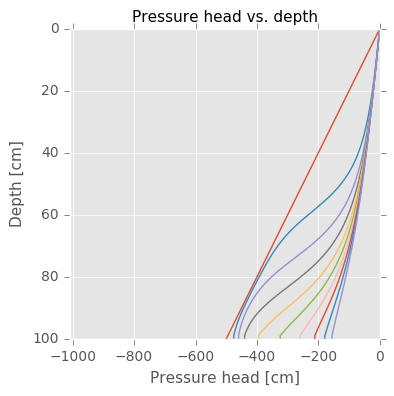

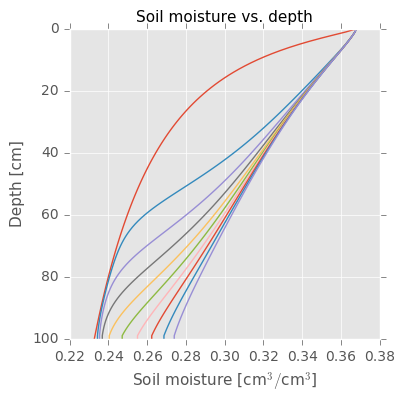

In [249]:
# Figures
plt.figure(1, figsize = (4,4)); 
plt.plot(hinit,z);
plt.xlabel('Pressure head [cm]',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.xlim( -1010, 0)
plt.gca().invert_yaxis()
plt.title('Pressure head vs. depth', fontsize=  11)
plt.figure(2, figsize = (4,4))
plt.plot(thetainit,z)
plt.xlabel('Soil moisture $cm^3/cm^3$',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.gca().invert_yaxis()
plt.title('Soil moisture vs. depth',fontsize=  11)

start_time = time.time()


# #Define the container for an iteration counter
iterations = np.zeros([nt-1,1]);

# # Initialize the Picard iteration solver
for i in range(1, nt): 
    hnp1m =  H[:,i-1]  
    #Enter the iteration step
    thetan = THETA[:,i-1]   
    #Define a dummy stopping variable
    stop_flag = 0
    # Define an iteration counter
    niter = 0
    while(stop_flag==0): # Get C,K,theta
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi); 
        #  Compute the individual elements of the A matrix for LHS
        Cdiag = np.diag(cnp1m); 
        kbarplus = (1/2.)*MPlus.dot(knp1m);
        Kbarplus = np.diag(kbarplus); 
        kbarminus = (1/2.)*MMinus.dot(knp1m);
        Kbarminus = np.diag(kbarminus); 
        A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - Kbarminus.dot(DeltaMinus)); 
        #  Compute the residual of MPFD (RHS)
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
            (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan); 
        # Compute deltam for iteration level m+1

        deltam = np.linalg.pinv(A).dot(R_MPFD)
        # Increment iteration counter and display number of iterations
        niter = niter + 1;
        if max(abs(deltam[1:(nz-1)]))<stop_tol:
            stop_flag = 1
            hnp1mp1 = hnp1m + deltam # Force boundary conditions       
            hnp1mp1[0] = htop;
            if BottomBoundCon==0:
                hnp1mp1[nz-1] = hbottom;
            elif (BottomBoundCon==1):
                hnp1mp1[nz-1] = hnp1m[nz-2];
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
            thetanp1mp1 = thetanp1m;
            knp1mp1 = knp1m
            cnp1mp1 = cnp1m            
            hnp1m = hnp1mp1; 
        else:
            hnp1mp1 = hnp1m + deltam;
            hnp1m = hnp1mp1; # Force boundary conditions
            hnp1m[0] = htop;
            if BottomBoundCon==0:
                hnp1m[nz-1] = hbottom;
            elif BottomBoundCon==1:
                hnp1m[nz-1] = hnp1m[nz-2];
    # Closes while(stop_flag==0) H(:,i) = hnp1mp1;
    THETA[:,i] = thetanp1mp1; 
    H[:,i] = hnp1mp1;
    K[:, i]= knp1mp1;
    C[:,i] = cnp1mp1;
    ktop[i] =  (K[0, i] + K[1, i])/2.  
    kbot[i] =  (K[-1, i] + K[-2, i])/2.   #(knp1mp1[-1] + knp1mp1[-2])/2.  
    error[i] = dz*np.sum(C[1:-1,i]*deltam[1:-1]) -  kbot[i]*(deltam[-1] - deltam[-2])*dt/dz \
         + ktop[i]*(deltam[1] - deltam[0])*dt/dz
    if (np.mod(i,10)==0):
        print i,
        plt.figure(1, figsize= (6,5))
        plt.plot(hnp1mp1,z)
        plt.xlabel('Pressure head [cm]')
        plt.ylabel('Depth [cm]')
        plt.ylim(100, 0)
        plt.figure(2, figsize= (6,5))
        plt.plot(thetanp1mp1,z)
        plt.xlabel('Soil moisture [cm$^3/$cm$^3$]')
        plt.ylabel('Depth [cm]')
        plt.ylim(100, 0)
    #    save number of iterations
    iterations[i-1] = niter;
print("--- %s seconds ---" % (time.time() - start_time))

In [250]:
# plt.imshow(THETA[:, 1:2000:10])

In [251]:
#  Celia 12a.
# Kp5 : K_{1/2}  ,  Kn5 : K_{N-1/2}
Kp5 = (K[1] + K[0])/2.
Kn5 = (K[-1] + K[-2])/2.

In [252]:
# plt.plot(Kp5)
# kbot - Kn5

In [253]:
fluxin =  -  ktop*((H[1] - H[0])/dz + 1.)*dt   # top flux

In [254]:
fluxout =  kbot*((H[-1] - H[-2])/dz + 1. )*dt # bottom flux
# fluxout =  kbot*((H[-1] - H[-2])/dz )*dt # bottom flux


In [255]:
THETAbar = (MPlus.dot(THETA) + MMinus.dot(THETA))/2.
newmass = (THETA[:-1, 1:] - THETA[:-1, :-1]).sum(0)   #  change in mass 
# newmass = (THETA[:, 1:] - THETA[:, :-1]).sum(0)   #  change in mass 
# newmass = (THETAbar[:, 1:] - THETAbar[:, :-1]).sum(0)/2.   #  change in mass 

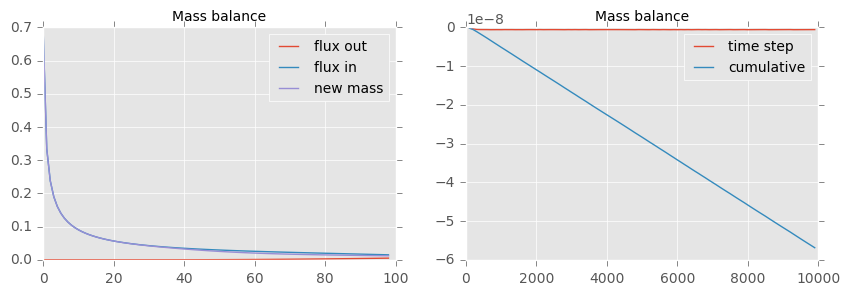

In [267]:
#  plot mass balance terms
plt.figure(1, figsize = (10,3))
ax = plt.subplot(121)
plt.title('Mass balance', fontsize = 10)
plt.plot(fluxout[1:], label = 'flux out')
plt.plot(fluxin[1:], label = 'flux in')
plt.plot(newmass, label = 'new mass')
plt.legend(fontsize = 10)
ax = plt.subplot(122)
plt.title('Mass balance', fontsize = 10)
plt.plot(t[1:], fluxin[1:] - newmass + fluxout[1:] - error[1:] ,  label = 'time step')
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:] - error[1:] ), label =  'cumulative')
# plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:]  ), '--', label =  'unclosed')
# plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass), label =  'cumulative')
plt.legend(fontsize = 10)
# (fluxin[1:] - newmass  + fluxout[1:] +error[1:])

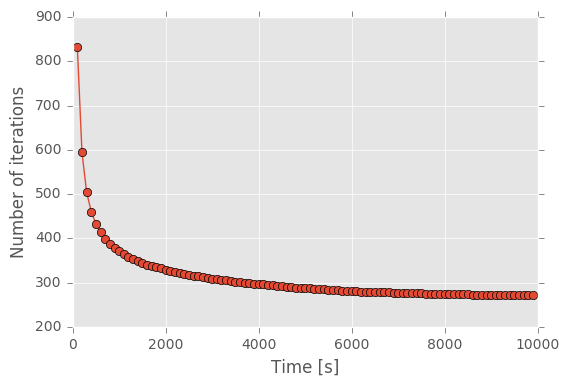

In [257]:
plt.figure(5);
plt.plot(t[1:nt],iterations,'o-');
plt.xlabel('Time [s]');
plt.ylabel('Number of iterations');

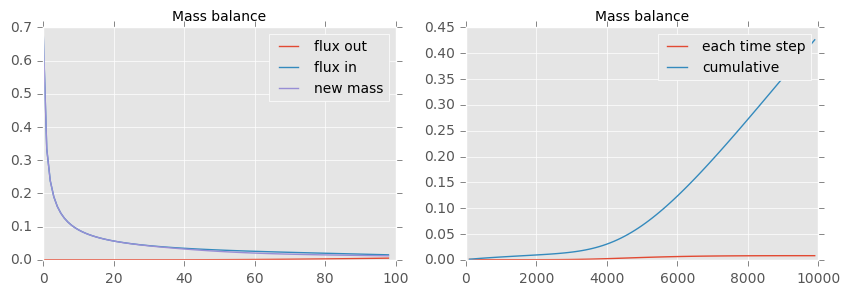

In [258]:
#  plot mass balance terms
plt.figure(1, figsize = (10,3))
ax = plt.subplot(121)
plt.title('Mass balance', fontsize = 10)
plt.plot(fluxout[1:], label = 'flux out')
plt.plot(fluxin[1:], label = 'flux in')
plt.plot(newmass, label = 'new mass')
plt.legend(fontsize = 10)
ax = plt.subplot(122)
plt.title('Mass balance', fontsize = 10)
plt.plot(t[1:], fluxin[1:] - newmass + fluxout[1:],  label = 'each time step')
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass+ fluxout[1:]), label =  'cumulative')
plt.legend(fontsize = 10)